# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
import logging
from pynverse import inversefunc
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sat May 21 21:21:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.73       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
| 36%   54C    P8    34W / 350W |    783MiB / 12288MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Taylor-Green

In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

## T = .25, nu = 2

Patch 0: generation of p samples take 417.0271499156952 seconds.
Patch  0: epoch    0 with loss 2.98E+00
Patch  0: epoch  500 with loss 4.69E-03
Patch  0: epoch 1000 with loss 1.58E-02
Patch  0: epoch 1500 with loss 1.11E-03
Patch  0: epoch 2000 with loss 1.02E-03
Patch  0: epoch 2500 with loss 1.03E-03
Patch  0: epoch 3000 with loss 1.02E-03
Patch  0: epoch 3500 with loss 9.98E-04
Patch  0: epoch 4000 with loss 9.76E-04
Patch  0: epoch 4500 with loss 9.51E-04
Patch  0: epoch 5000 with loss 9.21E-04
Patch  0: epoch 5500 with loss 8.88E-04
Patch  0: epoch 6000 with loss 8.52E-04
Patch  0: epoch 6500 with loss 8.20E-04
Patch  0: epoch 7000 with loss 7.84E-04
Patch  0: epoch 7500 with loss 7.62E-04
Patch  0: epoch 8000 with loss 7.51E-04
Patch  0: epoch 8500 with loss 7.41E-04
Patch  0: epoch 9000 with loss 7.83E-04
Patch  0: epoch 9500 with loss 7.48E-04
Patch  0: epoch 9999 with loss 7.63E-04
Patch0: pre-training of p with 10000 epochs takes  728 seconds.
Patch 0: generation of u sample

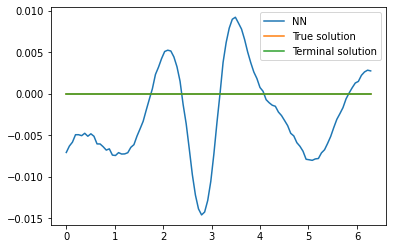

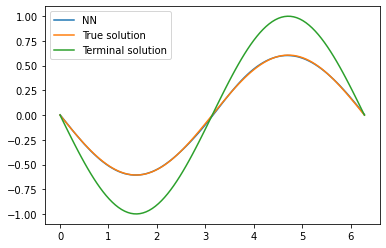

In [5]:
T, nu = .25, 2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

taylor_green_reuse_checkpoint = model.working_dir

## T = 1, nu = .2

Patch 0: generation of u samples take 935.210611820221 seconds.
Patch  0: epoch    0 with loss 5.41E-02
Patch  0: epoch  500 with loss 1.44E-04
Patch  0: epoch 1000 with loss 4.16E-04
Patch  0: epoch 1500 with loss 5.68E-05
Patch  0: epoch 2000 with loss 4.80E-05
Patch  0: epoch 2500 with loss 4.80E-05
Patch  0: epoch 3000 with loss 4.72E-05
Patch  0: epoch 3500 with loss 4.60E-05
Patch  0: epoch 4000 with loss 4.46E-05
Patch  0: epoch 4500 with loss 4.31E-05
Patch  0: epoch 5000 with loss 4.14E-05
Patch  0: epoch 5500 with loss 3.95E-05
Patch  0: epoch 6000 with loss 3.72E-05
Patch  0: epoch 6500 with loss 3.52E-05
Patch  0: epoch 7000 with loss 3.31E-05
Patch  0: epoch 7500 with loss 3.10E-05
Patch  0: epoch 8000 with loss 2.92E-05
Patch  0: epoch 8500 with loss 2.90E-05
Patch  0: epoch 9000 with loss 2.77E-05
Patch  0: epoch 9500 with loss 2.56E-05
Patch  0: epoch 9999 with loss 2.52E-05
Patch 0: training of u with 10000 epochs take 318.25275111198425 seconds.
The error as in Lejay 

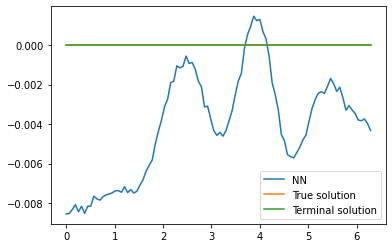

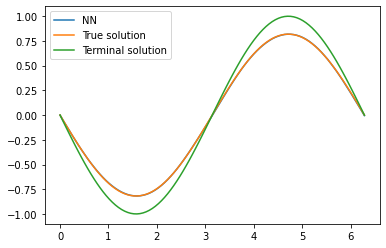

In [6]:
T, nu = 1, .2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

## T = 10, nu = .02

Patch 0: generation of u samples take 931.7045423984528 seconds.
Patch  0: epoch    0 with loss 2.45E-01
Patch  0: epoch  500 with loss 3.40E-04
Patch  0: epoch 1000 with loss 2.53E-04
Patch  0: epoch 1500 with loss 1.72E-04
Patch  0: epoch 2000 with loss 2.26E-04
Patch  0: epoch 2500 with loss 1.84E-04
Patch  0: epoch 3000 with loss 1.76E-04
Patch  0: epoch 3500 with loss 1.61E-04
Patch  0: epoch 4000 with loss 1.43E-04
Patch  0: epoch 4500 with loss 1.29E-04
Patch  0: epoch 5000 with loss 1.25E-04
Patch  0: epoch 5500 with loss 1.08E-04
Patch  0: epoch 6000 with loss 9.93E-05
Patch  0: epoch 6500 with loss 9.27E-05
Patch  0: epoch 7000 with loss 8.52E-05
Patch  0: epoch 7500 with loss 8.13E-05
Patch  0: epoch 8000 with loss 7.37E-05
Patch  0: epoch 8500 with loss 6.92E-05
Patch  0: epoch 9000 with loss 7.13E-05
Patch  0: epoch 9500 with loss 6.58E-05
Patch  0: epoch 9999 with loss 6.95E-05
Patch 0: training of u with 10000 epochs take 318.001433134079 seconds.
The error as in Lejay i

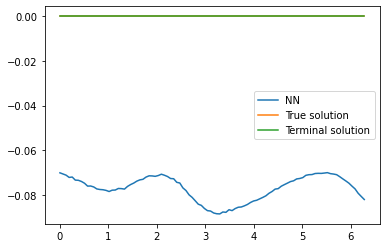

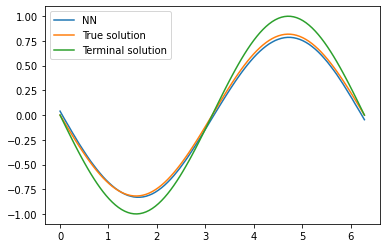

In [7]:
T, nu = 10, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

# ABC

In [8]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return (A * np.sin(x[2]) + C * np.cos(x[1])) * np.exp(-nu / 2 * (T - t))
    elif coordinate == 1:
        return (B * np.sin(x[0]) + A * np.cos(x[2])) * np.exp(-nu / 2 * (T - t))
    else:
        return (C * np.sin(x[1]) + B * np.cos(x[0])) * np.exp(-nu / 2 * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return (A * torch.sin(tx[3]) + C * torch.cos(tx[2])) * torch.exp(-nu / 2 * (T - tx[0]))
    elif coordinate == 1:
        return (B * torch.sin(tx[1]) + A * torch.cos(tx[3])) * torch.exp(-nu / 2 * (T - tx[0]))
    else:
        return (C * torch.sin(tx[2]) + B * torch.cos(tx[1])) * torch.exp(-nu / 2 * (T - tx[0]))

def exact_example_p_tensor(tx):
    return -torch.exp(-nu * (T - tx[0])) * (
        A * C * torch.sin(tx[3]) * torch.cos(tx[2])
        + B * A * torch.sin(tx[1]) * torch.cos(tx[3])
        + C * B * torch.sin(tx[2]) * torch.cos(tx[1])
    )

problem_name = "abc_3d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

## T = .7, nu = .02

Patch 0: generation of p samples take 939.7061104774475 seconds.
Patch  0: epoch    0 with loss 9.92E-01
Patch  0: epoch  500 with loss 1.07E-02
Patch  0: epoch 1000 with loss 2.89E-03
Patch  0: epoch 1500 with loss 2.52E-03
Patch  0: epoch 2000 with loss 2.07E-03
Patch  0: epoch 2500 with loss 2.08E-03
Patch  0: epoch 3000 with loss 2.03E-03
Patch  0: epoch 3500 with loss 1.95E-03
Patch  0: epoch 4000 with loss 1.86E-03
Patch  0: epoch 4500 with loss 1.75E-03
Patch  0: epoch 5000 with loss 1.61E-03
Patch  0: epoch 5500 with loss 1.47E-03
Patch  0: epoch 6000 with loss 1.33E-03
Patch  0: epoch 6500 with loss 1.18E-03
Patch  0: epoch 7000 with loss 1.02E-03
Patch  0: epoch 7500 with loss 8.72E-04
Patch  0: epoch 8000 with loss 7.55E-04
Patch  0: epoch 8500 with loss 6.52E-04
Patch  0: epoch 9000 with loss 5.71E-04
Patch  0: epoch 9500 with loss 5.13E-04
Patch  0: epoch 9999 with loss 4.59E-04
Patch0: pre-training of p with 10000 epochs takes 1078 seconds.
Patch 0: generation of u sample

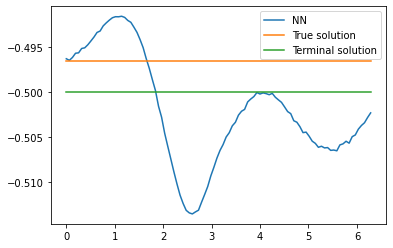

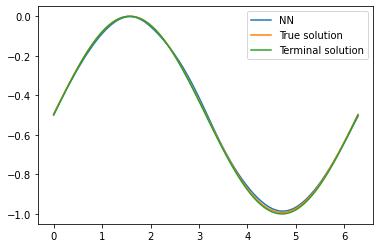

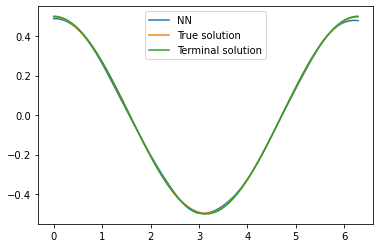

In [9]:
T, nu = .7, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

abc_reuse_checkpoint = model.working_dir

## T = .7, nu = .0002

Patch 0: generation of u samples take 3312.6908071041107 seconds.
Patch  0: epoch    0 with loss 8.82E-05
Patch  0: epoch  500 with loss 2.93E-04
Patch  0: epoch 1000 with loss 9.90E-05
Patch  0: epoch 1500 with loss 9.07E-05
Patch  0: epoch 2000 with loss 8.13E-05
Patch  0: epoch 2500 with loss 8.03E-05
Patch  0: epoch 3000 with loss 7.88E-05
Patch  0: epoch 3500 with loss 7.70E-05
Patch  0: epoch 4000 with loss 7.47E-05
Patch  0: epoch 4500 with loss 7.20E-05
Patch  0: epoch 5000 with loss 6.88E-05
Patch  0: epoch 5500 with loss 6.52E-05
Patch  0: epoch 6000 with loss 6.11E-05
Patch  0: epoch 6500 with loss 5.67E-05
Patch  0: epoch 7000 with loss 5.20E-05
Patch  0: epoch 7500 with loss 4.71E-05
Patch  0: epoch 8000 with loss 4.23E-05
Patch  0: epoch 8500 with loss 3.76E-05
Patch  0: epoch 9000 with loss 3.31E-05
Patch  0: epoch 9500 with loss 2.90E-05
Patch  0: epoch 9999 with loss 2.55E-05
Patch 0: training of u with 10000 epochs take 446.5323190689087 seconds.
The error as in Lejay

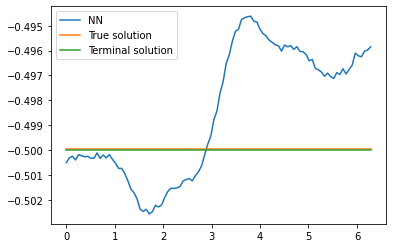

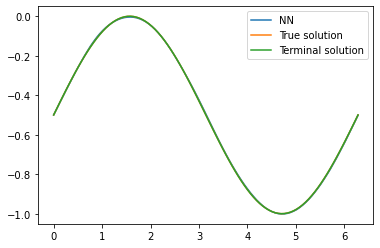

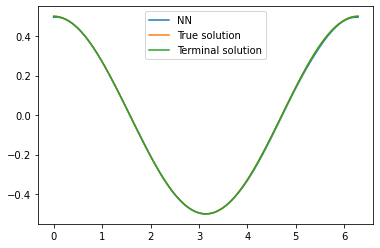

In [10]:
T, nu = .7, .0002

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=abc_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))